In [50]:
import pandas as pd
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("./stock_historical_data/{}.csv".format("LT.NS"))
df.set_index("Date", inplace=True)
df["date"] = df.index

In [3]:
new_df = pd.DataFrame(df.Close)
new_df.reset_index(inplace=True)

In [5]:
new_df = new_df.drop("Date",axis=1)


KeyError: "['Date'] not found in axis"

In [6]:
new_df

Close
0    1226.583862
1    1259.684326
2    1250.086548
3    1232.951172
4    1236.462646
..           ...
885  2560.899902
886  2646.250000
887  2660.199951
888  2649.550049
889  2681.350098

[890 rows x 1 columns]

In [7]:
#scaling fream
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
new_df = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [8]:
##splitting dataset into train and test split
training_size = int(len(new_df)*0.8)
test_size     = len(new_df) - training_size
train_data,test_data = new_df[0:training_size,:],new_df[training_size:len(new_df),:1]

In [9]:
new_df.shape,train_data.shape,test_data.shape

((890, 1), (712, 1), (178, 1))

In [10]:
train_data.shape , test_data.shape

((712, 1), (178, 1))

In [11]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[(i+time_step)+1][0])

    return numpy.array(dataX), numpy.array(dataY)

In [12]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest    = create_dataset(test_data, time_step)

In [13]:
X_train.shape,y_train.shape,X_test.shape,ytest.shape

((611, 100), (611,), (77, 100), (77,))

In [14]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [15]:
X_test.shape

(77, 100, 1)

In [16]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

2023-08-07 17:22:48.642792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=2,batch_size=64,verbose=1)

Epoch 1/2
10/10 [==============================] - 12s 475ms/step - loss: 0.0648 - val_loss: 0.0040
Epoch 2/2
10/10 [==============================] - 2s 226ms/step - loss: 0.0090 - val_loss: 0.0483


In [20]:
import tensorflow as tf

In [21]:
### Lets Do the prediction and check performance metrics
train_predict =  model.predict(X_train)
test_predict  =  model.predict(X_test)

3/3 [==============================] - 0s 43ms/step


In [22]:
##Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict  = scaler.inverse_transform(test_predict)

In [23]:
test_predict

array([[1859.3462],
       [1861.1282],
       [1863.817 ],
       [1867.2476],
       [1871.0864],
       [1874.8679],
       [1878.3047],
       [1881.2585],
       [1883.7351],
       [1885.6919],
       [1887.1946],
       [1888.4022],
       [1889.5508],
       [1890.9045],
       [1892.8423],
       [1895.601 ],
       [1899.0842],
       [1903.126 ],
       [1907.6311],
       [1912.4137],
       [1917.3336],
       [1922.2169],
       [1926.3982],
       [1929.4136],
       [1931.2074],
       [1931.7816],
       [1931.214 ],
       [1929.5295],
       [1926.8657],
       [1923.5365],
       [1919.7362],
       [1915.5892],
       [1911.3162],
       [1907.1547],
       [1903.2913],
       [1899.7727],
       [1896.5934],
       [1893.7506],
       [1891.3525],
       [1889.5928],
       [1888.5823],
       [1888.4827],
       [1889.4131],
       [1891.4332],
       [1894.3533],
       [1898.0056],
       [1902.1995],
       [1906.7649],
       [1911.5554],
       [1916.4255],


In [24]:
train_predict.shape,test_predict.shape
result = np.concatenate((train_predict, test_predict), axis=0)
result.shape,train_predict.shape

((688, 1), (611, 1))

In [25]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1442.6243169503978

In [26]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1925.182640944753

(77, 1)

In [48]:
real_data = scaler.inverse_transform(ytest.reshape(77,1))
real_data = d.reshape(77)
pred = test_predict.reshape(77)
predic_res = []
real_res = []

for x in range(len(pred)-1):
    if pred[x] > pred[x+1]:
        predic_res.append(0)
    else:
        predic_res.append(1)
    if real_data[x] > real_data[x+1]:
        real_res.append(0)
    else:
        real_res.append(1)

test_df = pd.DataFrame({ "real" : real_res,"test_predict":predic_res})
#test_df
#test_df

In [55]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_df["real"], test_df["test_predict"])
print(accuracy)

0.5131578947368421


<Axes: xlabel='test_predict'>

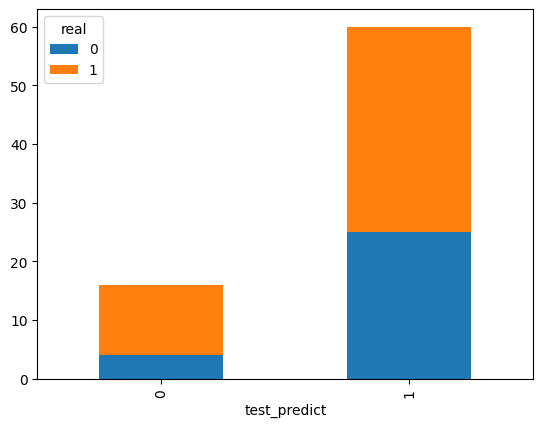

In [56]:
ct = pd.crosstab(test_df["test_predict"],test_df["real"])
ct.plot(kind="bar",stacked=True)

In [54]:
ct

test_predict   0   1
real                
0              4  25
1             12  35

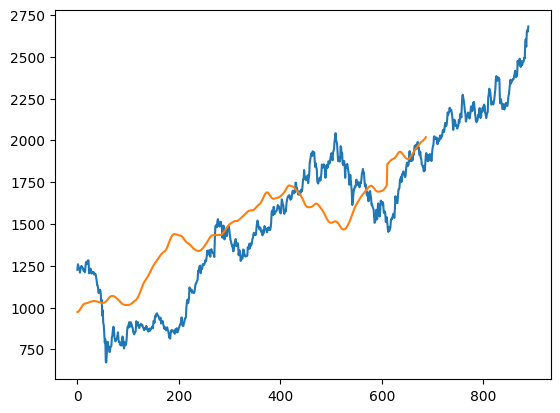

In [27]:
### Plotting 
# shift train predictions for plotting
look_back=100
#trainPredictPlot = numpy.empty_like(df1)
#trainPredictPlot[:, :] = np.nan
#trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
#testPredictPlot = numpy.empty_like(df1)
#testPredictPlot[:, :] = numpy.nan
#testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(new_df))
plt.plot(result)
#plt.plot(train_predict)
plt.show()

In [110]:
new_df.shape,trainPredictPlot.shape,testPredictPlot.shape

((890, 1), (890, 1), (890, 1))